As a cytogeneticist studying some features of the chromosomes (their telomeres, structural anomalies ...), you need to take pictures from chromosomal preparations fixed on glass slides . Unfortunately, like the sticks in the mikado game, sometime a chromosome or more can fall on an other one yielding overlapping chromosomes in the image, the plague of cytogeneticists. 
Computer based methods relying on geometric approaches, were developped to try to overcome this problem (Lunsteen & Piper, Minaee et al.). It seems possible that supervised methods based (NN) could learn to recognize overlapping domains of overlapping chromosomes. 
Overlapping chromosomes can be found by screening them in metaphases but they can be generated by systematically combining single chromosomes, possibly as follow:

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.5/site-packages')
import cv2

ImportError: No module named 'cv2'

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import h5py
import sys
import itertools
import numpy as np # linear algebra
from scipy import ndimage as nd
import skimage as sk
from skimage import segmentation as skg
from skimage.measure import label
from skimage import io


from matplotlib import pyplot as plt
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [4]:
from subprocess import check_output
print(check_output(["ls", "../dataset"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

Cy3.tif
DAPI.tif
LowRes_13434_overlapping_pairs.h5
overlapping_chromosomes_examples.h5



In [5]:
cy3_12 = nd.imread('../dataset/Cy3.tif')[50:900,300:1150]
dapi_12 = nd.imread('../dataset/DAPI.tif')[50:900,300:1150]

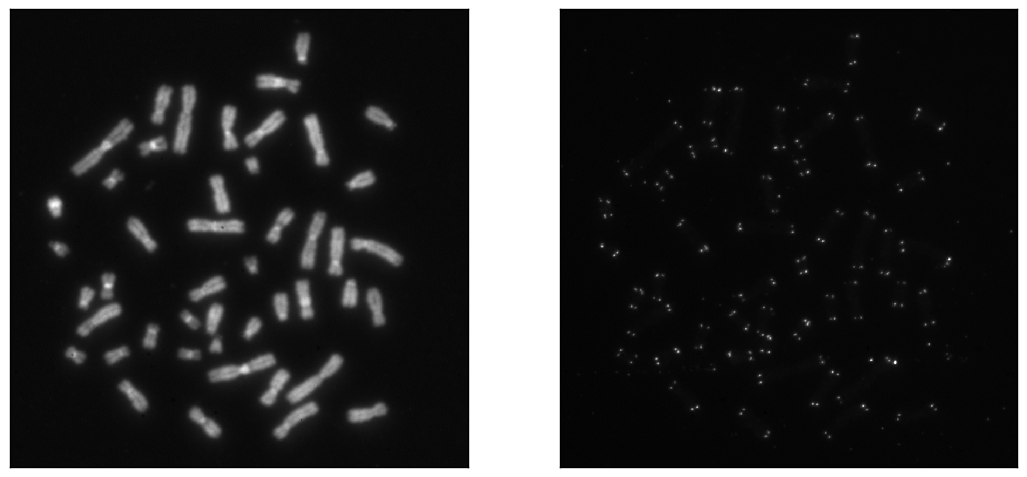

In [6]:
%matplotlib inline
plt.figure(figsize=(13, 15))
plt.subplot(121, xticks=[], yticks=[])
plt.imshow(dapi_12,  interpolation = 'nearest', cmap=plt.cm.gray)
plt.subplot(122,xticks=[], yticks=[])
plt.imshow(cy3_12, interpolation = 'nearest', cmap=plt.cm.gray)

### Let's define some tools for:

 - Extracting patch of an image knowing a label.
 - Resizing images.
 - Generating overlapping chromosomes from a pair of single chromosomes.

In [32]:
def extractParticles_2(greyIm, LabIm):
    #print 'start', greyIm.dtype, LabIm.dtype
    LabelImg= LabIm
    GreyImg = greyIm
    locations = nd.find_objects(LabelImg)
    
    #print locations
    i=1
    extracted_images=[]
    for loc in locations:
        
        lab_image = np.copy(LabelImg[loc])
        grey_image = np.copy(GreyImg[loc])
        
        lab_image[lab_image != i] = 0
        grey_image[lab_image != i] = 0
        extracted_images.append(grey_image)
        i=i+1
    return extracted_images

In [30]:
def ResizeImages(ImList):
        '''Find the largest width and height of images belonging to a list.
        Return a list of images of same width/height
        '''
        maxwidth=0
        maxheight=0
        if len(np.shape(ImList[0]))==3:
            components = np.shape(ImList[0])[2]
        imtype = ImList[0].dtype
        for i in range(len(ImList)):
            width=np.shape(ImList[i])[1]#width=column
            height=np.shape(ImList[i])[0]#height=line
            #print "width:height",width,":",height
            if width>maxwidth:maxwidth=width
            if height>maxheight:maxheight=height
        #print "maxwidth:maxheight",maxwidth,":",maxheight
        NewList=[]
        for i in range(0,len(ImList)):
            width=np.shape(ImList[i])[1]
            height=np.shape(ImList[i])[0]

            diffw=maxwidth-width
            startw=round(diffw/2)
            diffh=maxheight-height
            starth=int(round(diffh/2))
            startw=int(round(diffw/2))
            if len(np.shape(ImList[0]))==3:
                newIm=np.zeros((maxheight,maxwidth,components), dtype=imtype)
                newIm[starth:starth+height,startw:startw+width,:]=ImList[i][:,:,:]
                NewList.append(newIm)
            if len(np.shape(ImList[0]))==2:
                newIm=np.zeros((maxheight,maxwidth), dtype=imtype)
                newIm[starth:starth+height,startw:startw+width]=ImList[i][:,:]
                NewList.append(newIm)
        return NewList
    
def clip_img_to_bounding_box(img):
    bb = nd.find_objects(img[:,:,-1]>0)
    slice0 = bb[0][0]
    slice1= bb[0][1]
    clip = img[slice0,slice1]
    return clip

def patch_to_square(image, seepatch=False):
    if seepatch==True:
        s1=2
        s2=3
    else:
        s1=0
        s2=0
    row = image.shape[0]
    col = image.shape[1]
    Hyp = int(np.ceil(np.sqrt(row**2+col**2)))+1
    drow = int(np.ceil(Hyp-row)/2)
    dcol = int(np.ceil(Hyp-col)/2)
    patch_h= s1*np.ones((row,dcol),dtype=int)
    patch_v= s2*np.ones((drow,col+2*(dcol)), dtype=int)
    e2 = np.hstack((patch_h, image, patch_h))
    return np.vstack((patch_v,e2,patch_v))

def rotated_images(image, step_angle, half_turn = False):
    if half_turn == True:
        angle_max = 180
    else:
        angle_max = 360
    angles = np.arange(0, angle_max, step_angle)
    return [clip_img_to_bounding_box(nd.rotate(image, rotation)) for rotation in angles]

def collection_of_pairs_of_rotated_images(image1, image2, step_angle=10, half_turn=False):
    '''Take two images, rotate them all by "step_angle".
    Make all possible pairs by cartesian product
    then resize them such same shape(size)
    '''

    r_images1 = rotated_images(image1, step_angle, half_turn)
    r_images2 = rotated_images(image2, step_angle, half_turn)

    pairs = itertools.product(r_images1, r_images2)
    #print type(next(pairs))
    #print next(pairs)
    r_pairs = [ResizeImages([p[0],p[1]]) for p in pairs]
    return r_pairs

def translate(image, vector):
    #print 'vector',vector, vector[0]
    image = np.roll(image, int(vector[0]), axis = 0)
    image = np.roll(image, int(vector[1]), axis = 1)
    return image

def add_mask_to_image(image, mask_value = 1):
    image = np.dstack((image, mask_value*(image>0)))
    return image

def merge_and_roll(still_img, move_img, row, col, clip=True):
    '''row, col: assume two numbers in [0,1]
    images:last component supposed to be a mask
    '''
    u=row
    v=col

    target = np.copy(still_img)
    source = np.copy(move_img)
    #print target.shape, source.shape

    #bounding boxes
    bb0 = nd.find_objects(target[:,:,-1]>0)
    bb1 = nd.find_objects(source[:,:,-1]>0)
    #won't work if more than two components C0 and C1
    C_0 = target[bb0[0][0],bb0[0][1]]
    C_1 = source[bb1[0][0],bb1[0][1]]
    #col, row
    c1 = C_1.shape[1]
    r1 = C_1.shape[0]
    c0 = C_0.shape[1]
    r0 = C_0.shape[0]
    comp = C_0.shape[-1]
    #print 'c1,r1,c0,r0, comp:',c1,r1,c0,r0, comp

    still = np.zeros((r1+2*r0,c1+2*c0,comp),dtype=int)
    still[r0+1:r0+r1+1,c0+1:c0+c1+1]= C_1
    move = np.zeros(still.shape, dtype=int)
    move[:r0,:c0]=C_0
    vector = u*(still.shape[0]-r0),v*(still.shape[1]-c0)
    #print r1, c1, vector
    move = translate(move, vector)
    #merge_shape =
    #figsize(10,8)
    merge = move+still
    if clip==False:
        return merge
    else:
        return clip_img_to_bounding_box(merge)

    
def overlapping_generator(image1, image2, mask1 = 1, mask2 = 2, 
                          rotation_step = 30, translations_number = 9,turn = False):
    '''
    * This function takes two greyscaled images of chromosomes on black backaground
    * add a mask to each image:
        + same value for each mask (1 and 1) so that the overlapping pixels are set to 2.
        + different values for each mask (1 and 2) so that the overlapping pixels are set to 3.
    * rotate one chromosome of a multiple of a fixed angle in degree and make a pair of chromosomes
    (rotated, fixed position).
    *perform relative translations of one chromosome with a given number
    *returns a list of merged pair of images.
    '''
    c0 = clip_img_to_bounding_box(add_mask_to_image(image1, mask_value = mask1))
    c1 = clip_img_to_bounding_box(add_mask_to_image(image2,mask_value = mask2))
    
    CR = collection_of_pairs_of_rotated_images(c0, c1, step_angle = rotation_step, half_turn= turn)
    
    #Prepare translation vectors u (same on rows and lines)
    u = np.linspace(0,1,num = translations_number, endpoint = True)[1:-1]
    #v = np.arange(0,1,0.2)[1:]
    P = [t for t in itertools.product(u,u)]
    
    overlappings = []
    #Take a pair of images
    for pair_of_images in CR:# CR[::3] Just play with a subset
        im1 = pair_of_images[0]
        im2 = pair_of_images[1]
        #Now translate one image relative to the other one
        for t in P:#P[::3]Just play with a subset
            u = t[0]
            v = t[1]
            #translations = [merge_and_roll(im1, im2, u, v) for t in P]
            #overlappings.append(translations)
            overlappings.append(merge_and_roll(im1, im2, u, v))

    overlapping_chrom_learning_set = ResizeImages(overlappings)
    return overlapping_chrom_learning_set

### Let's define structuring elements for further image segmentation

In [9]:
### There's a problem with opencv in a python3 virtual env in ubuntu 16.04
#kernel100 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50))
#kernel18 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))

### so try another lib for top-hat filtering (much slower than opencv)
kernel100 = sk.morphology.disk(50)
kernel18 = sk.morphology.disk(9)

## Let's convert the 12 bits images into 8 bits:

 - easier to handle for segmentation.
 - needed to make a rgb image.

In [10]:
d8 = np.uint8(dapi_12/16.0)
cy8 = np.uint8(cy3_12/16.0)


### Let's make images with background set to zero

In [ ]:
#Prefer to use opencv if possible
#dapi_cv = cv2.morphologyEx(d8, cv2.MORPH_TOPHAT, kernel100)
#cy3_cv = cv2.morphologyEx(cy8, cv2.MORPH_TOPHAT, kernel18)

dapi_cv = sk.morphology.white_tophat(d8, selem = kernel100)

In [12]:
cy3_cv = sk.morphology.white_tophat(cy8, selem = kernel18)

dapi_cv = 1.0*dapi_cv - 5
dapi_cv[dapi_cv <0] = 0
dapi_cv = np.uint8(dapi_cv)

cy3_cv = 1.0*cy3_cv - 5
cy3_cv[cy3_cv<0] = 0
cy3_cv = np.uint8(cy3_cv)

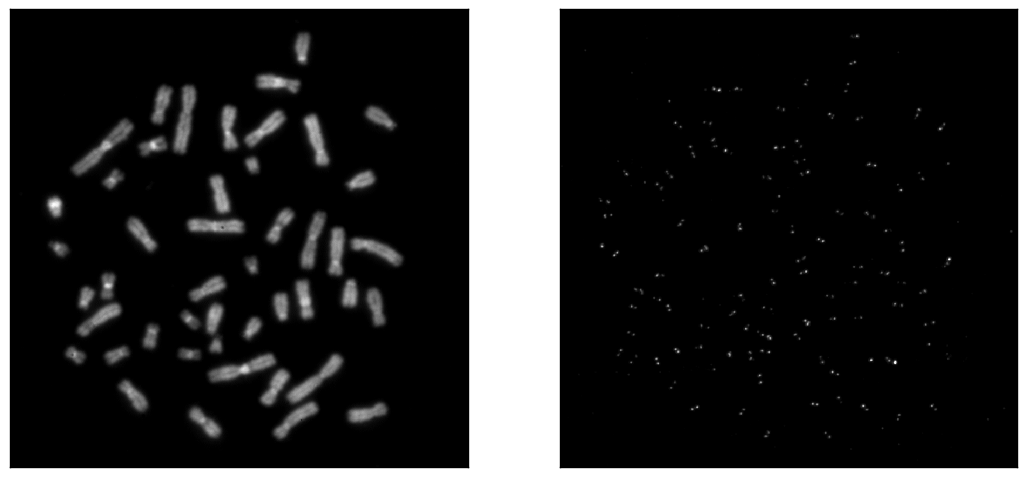

In [13]:
plt.figure(figsize=(13, 15))
plt.subplot(121, xticks=[], yticks=[])
plt.imshow(dapi_cv,  interpolation = 'nearest', cmap=plt.cm.gray)
plt.subplot(122,xticks=[], yticks=[])
plt.imshow(cy3_cv, interpolation = 'nearest', cmap=plt.cm.gray)

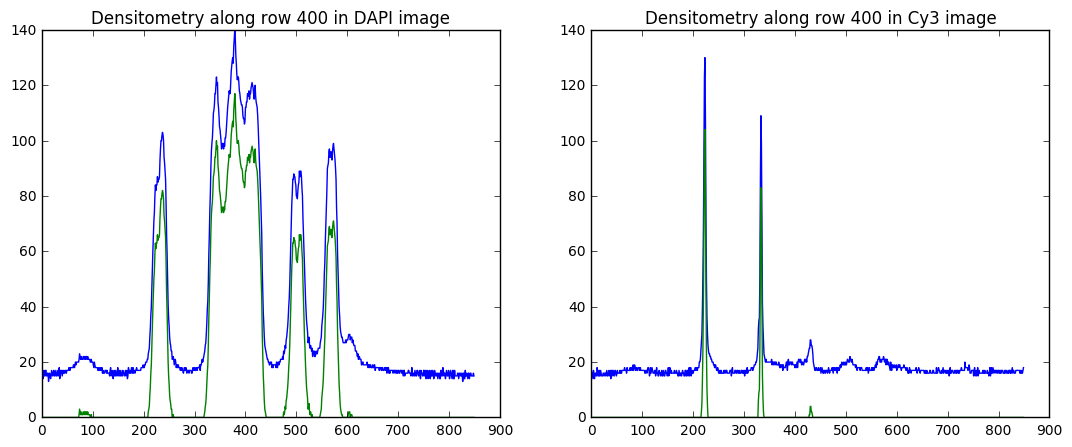

In [24]:
plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.title('Densitometry along row 400 in DAPI image')
plt.plot(d8[400,:])
plt.plot(dapi_cv[400,:])
plt.subplot(122)
plt.title('Densitometry along row 400 in Cy3 image')
plt.plot(cy8[400,:])
plt.plot(cy3_cv[400,:])

Combine the two images into a rgb image

In [25]:
red = np.uint8(cy3_cv)
green = np.zeros(cy3_cv.shape, dtype=np.uint8)
blue = np.uint8(dapi_cv)

color = np.dstack((red, green, blue))

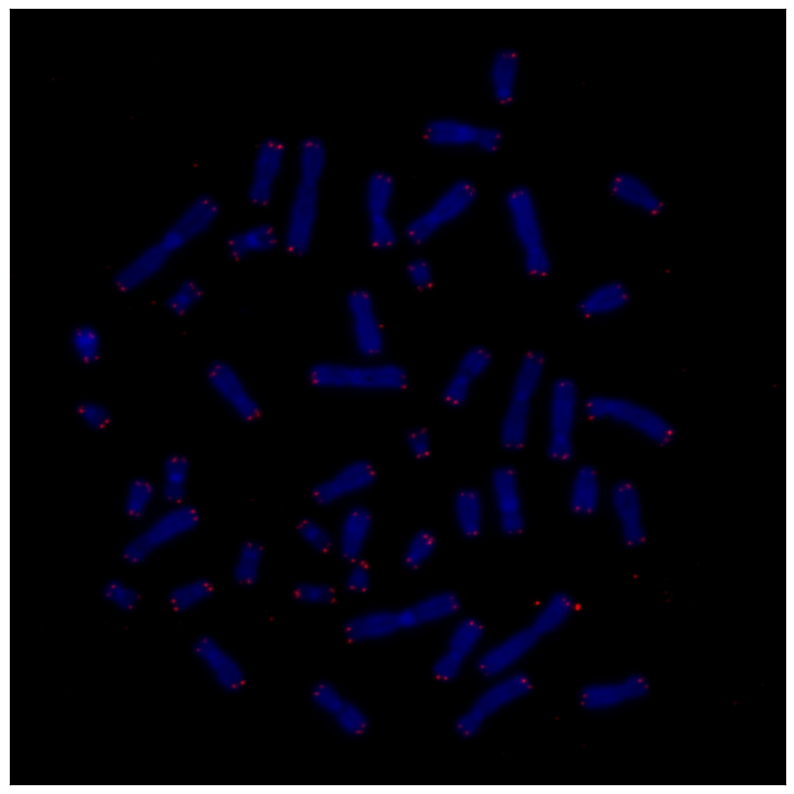

In [26]:
plt.figure(figsize=(10,10))
plt.subplot(111, xticks=[], yticks=[])
plt.imshow(color)

## Start chromosomes segmentation

In [27]:
seg =  sk.filters.threshold_adaptive(dapi_cv, block_size = 221)
seg = sk.morphology.binary_opening(seg, selem = sk.morphology.disk(5))
sk.segmentation.clear_border(seg, buffer_size=3, in_place= True)
labelled = label(seg)

In [28]:
dapi_cy3 = (1.0*dapi_cv + 1.0*cy3_cv)/2
combined = np.uint8(255*sk.exposure.rescale_intensity(dapi_cy3))

In [33]:
single_chroms = extractParticles_2(combined, labelled)
resized_chroms = ResizeImages(single_chroms)

singles_rgb = extractParticles_2(color, labelled)
resized_rgb = ResizeImages(singles_rgb)

**Let's have a look at the extracted chromosomes**

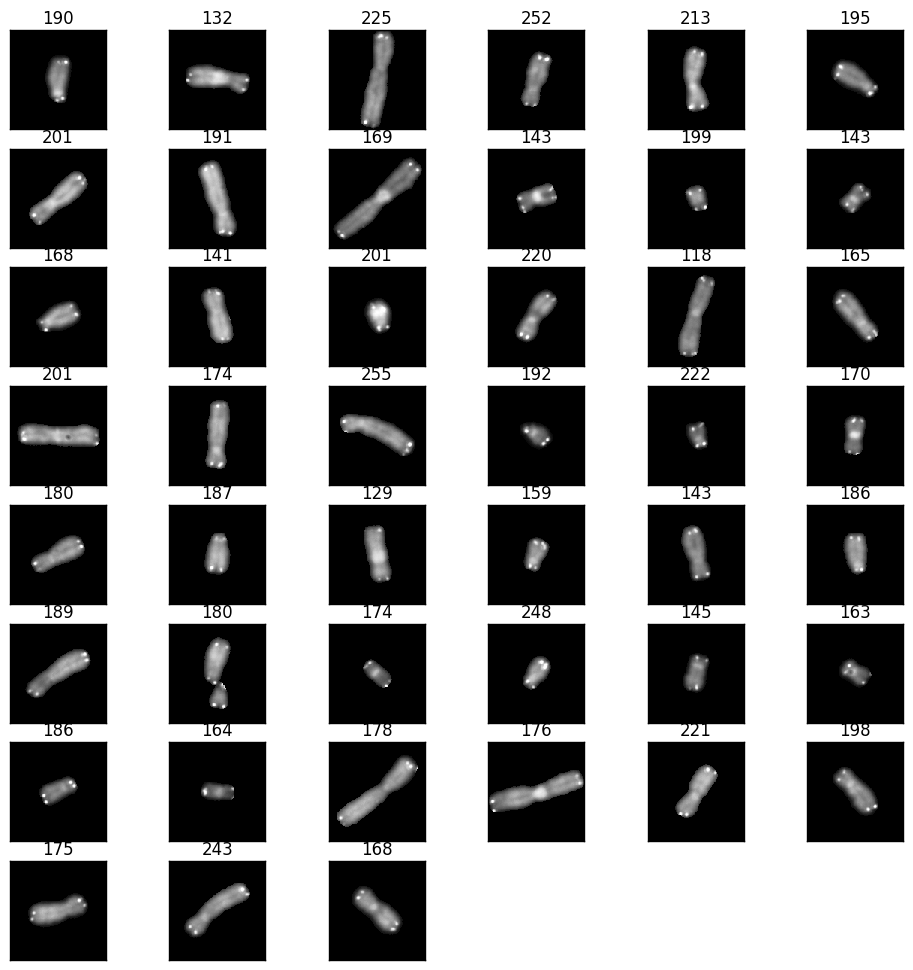

In [34]:
plt.figure(figsize=(12, 12))
for i, image in enumerate(resized_chroms):#in range(46):#
    plt.subplot(8,6,i+1, xticks=[],yticks=[])
    #image = chroms_stack[i,:,:]
    plt.imshow(image, interpolation='nearest', cmap = plt.cm.Greys_r, vmin=0,vmax=150)
    plt.title(str(image.max()))

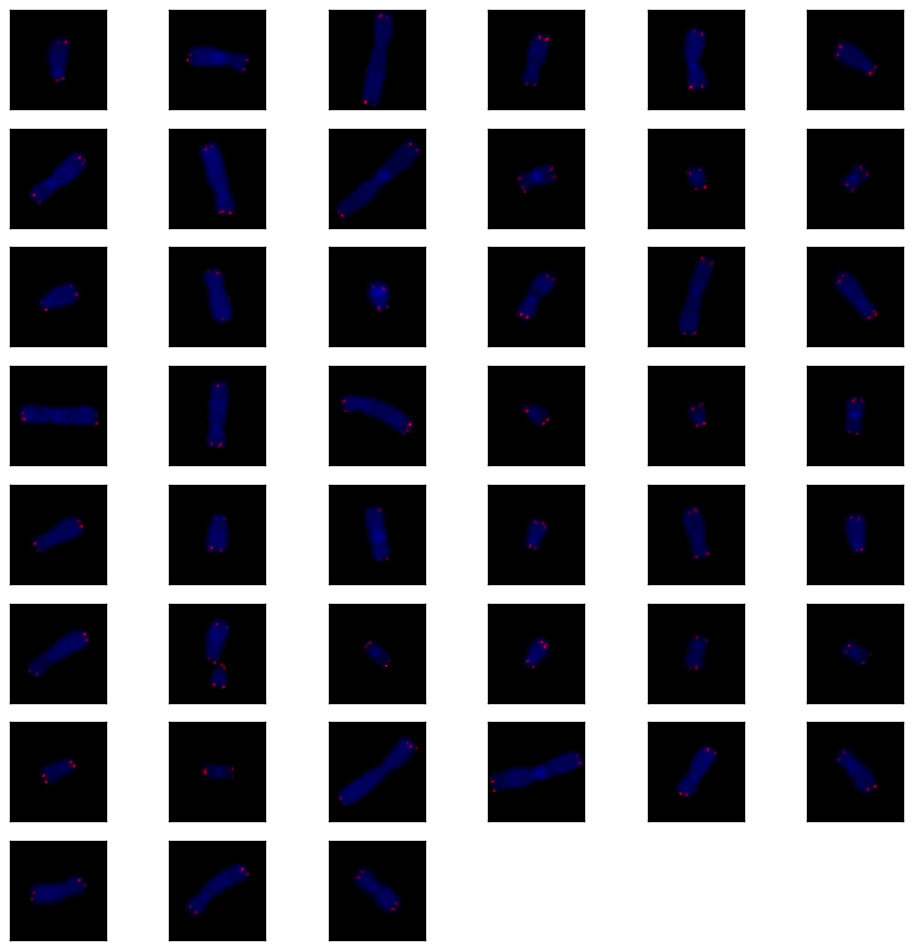

In [35]:
plt.figure(figsize=(12, 12))
for i, image in enumerate(resized_rgb):#in range(46):#
    plt.subplot(8,6,i+1, xticks=[],yticks=[])
    #image = chroms_stack[i,:,:]
    plt.imshow(image, interpolation='nearest')

# Now that single chromosomes are available, they can be combined to generate overlapping chromosomes.
First let's start by making pairs of chromosomes,even if overlapping chromosomes can be more complex implicating several chromosomes.

### Chromosomes can be ordered  by size

In [36]:
singles = {}
for chrom in resized_chroms:
    size = np.sum(chrom > 0)
    singles[size] = chrom
keys = singles.keys()
sorted_size = sorted(keys)
half_karyotype = []

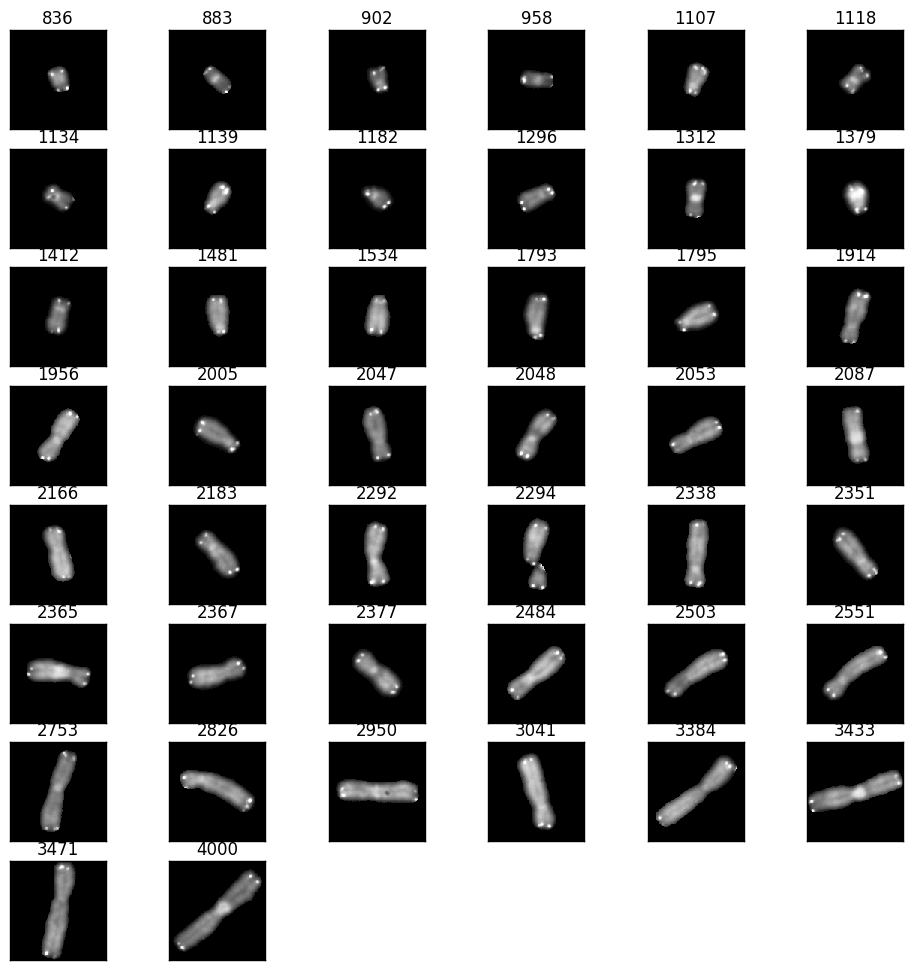

In [37]:
plt.figure(figsize=(12, 12))
for i, siz in enumerate(sorted_size):#in range(46):#
    plt.subplot(8,6,i+1, xticks=[],yticks=[])
    #image = chroms_stack[i,:,:]
    plt.imshow(singles[siz], interpolation='nearest', cmap = plt.cm.Greys_r, vmin=0,vmax=150)
    plt.title(str(siz))

In [38]:
all_pairs = []
for pair in itertools.combinations(resized_chroms, 2):
    area1 = np.sum(pair[0]>0)
    area2 = np.sum(pair[1]>0)
    all_pairs.append(((area1, area2), pair))
print(len(all_pairs),' pairs of chromosomes generated')

990  pairs of chromosomes generated


One of the pairs can be displayed, for example the 500 pair:

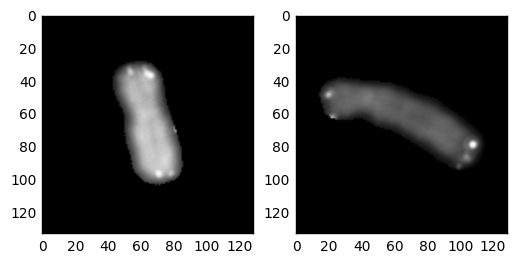

In [39]:
im1 = all_pairs[500][1][0]
im2 = all_pairs[500][1][1]

plt.subplot(121)
plt.imshow(im1, cmap = plt.cm.Greys_r)
plt.subplot(122)
plt.imshow(im2, cmap = plt.cm.Greys_r)

### Let's generate chromosome overlapps:
Each chromosome is rotated by an angle value, for eg 36° yielding 10x10 pairs of images then for each pair one chromosome is translated horizontally and vertically yielding more examples of possible chromosome overlapps. Finally, non overlapping chromosomes are discarded.
The more rotation angle is small and the more le translation number is large, the more the number of overlapping chromosomes is large et potentially overcome the RAM capacity.

In [40]:
candidates_overlapps = []
onepair = all_pairs[500]#let's take a pair in the 1035 possible pairs
for pair in onepair:#all_pairs[] DO NOT  HOLD in RAM
    im1 = pair[0]
    im2 = pair[1]
    overl = overlapping_generator(im1,im2,rotation_step=36, translations_number=7, turn = False)
    candidates_overlapps = candidates_overlapps + overl

In [41]:
print(len(candidates_overlapps))

5000


## Let's remove the examples where the two chromosomes do not touch or overlapp:

In [42]:
overlapps = []
for ovlp in candidates_overlapps:
    if np.any(ovlp[:,:,1][:,:]==3):
        overlapps.append(ovlp)
print(len(overlapps),' examples')

2090  examples


In [43]:
stacked = io.concatenate_images(overlapps)
print(stacked.shape)
print('Shuffling images')
np.random.shuffle(stacked)
print(stacked.shape)

(2090, 154, 154, 2)
Shuffling images
(2090, 154, 154, 2)


In [44]:
kilo_byte = sys.getsizeof(overlapps[0])/1024
print('Each image (grey+ground truth) weights:',kilo_byte,' kbytes')
print('Size of stacked images ',sys.getsizeof(stacked)/1024/1024,' Mo')

Each image (grey+ground truth) weights: 370.6875  kbytes
Size of stacked images  756.3239898681641  Mo


## Let' visualize a sample from the 1957 examples for these two chromosomes to overlapp.

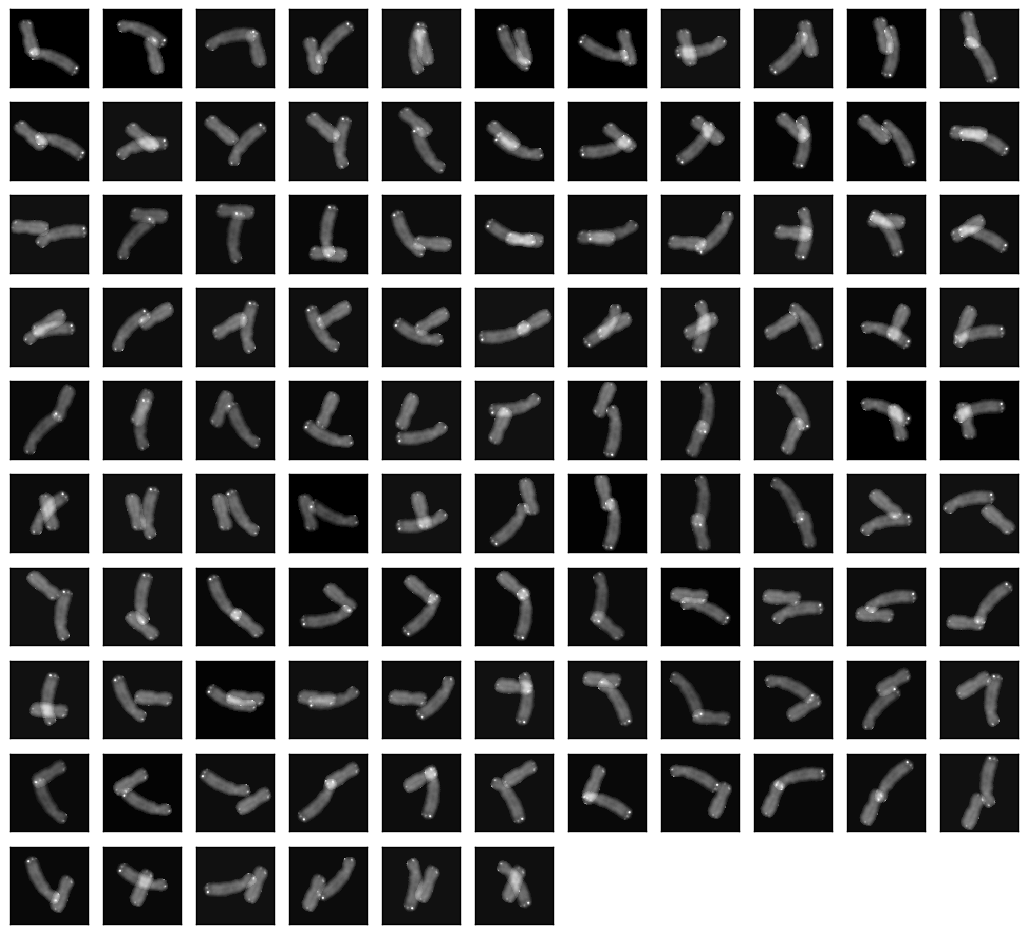

In [45]:
plt.figure(figsize=(13, 13))
for i, im in enumerate(overlapps[::20]):
    plt.subplot(11,11,i+1, xticks=[],yticks=[])
    plt.imshow(im[:,:,0], interpolation='nearest', cmap = plt.cm.Greys_r)

## Let's show the labels ('groundtruth') where the value = 3 (blue) indicate pixels belonging to a chromosome overlapp.

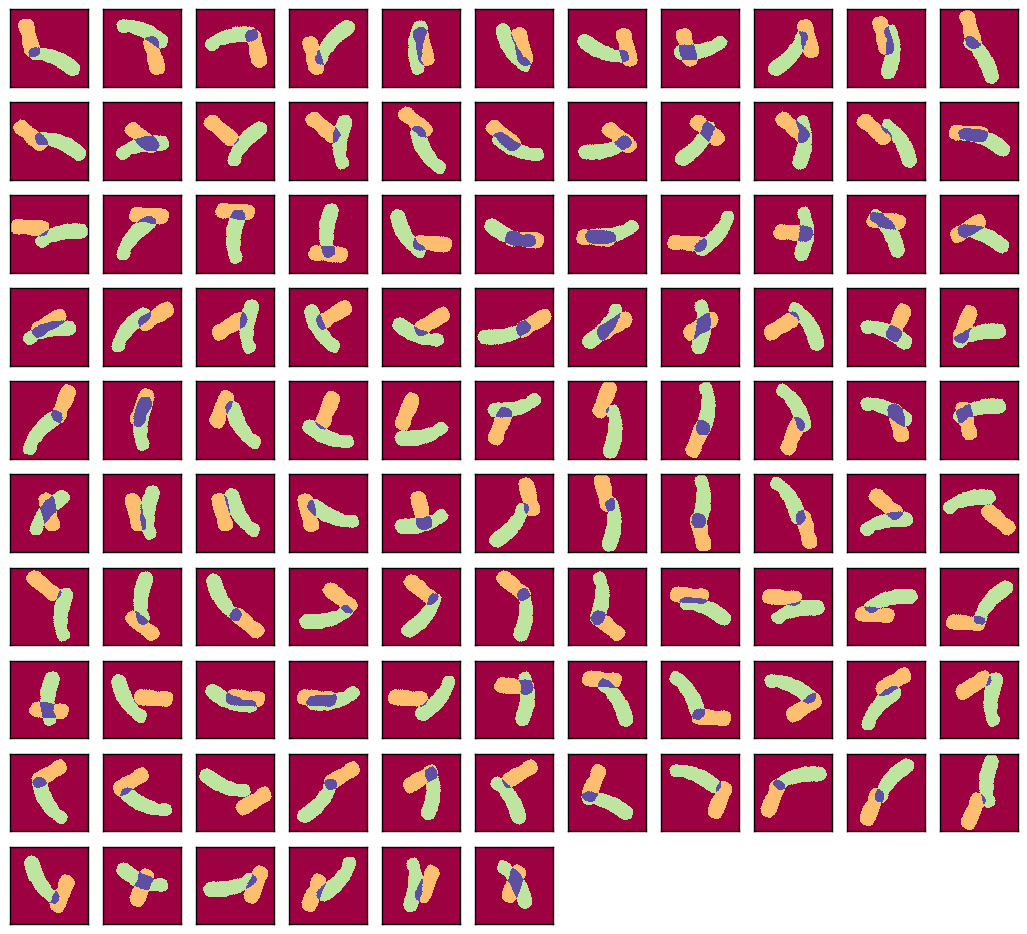

In [46]:
plt.figure(figsize=(13, 13))
for i, im in enumerate(overlapps[::20]):
    plt.subplot(11,11,i+1, xticks=[],yticks=[])
    plt.imshow(im[:,:,1], interpolation='nearest', cmap = plt.cm.Spectral,vmin=0, vmax=3)

## Let's look at one example

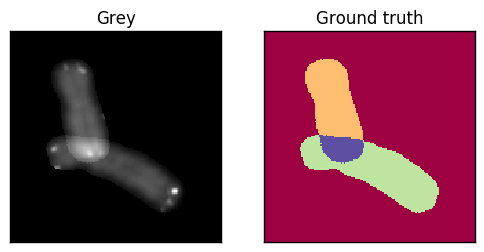

In [61]:
example = overlapps[1]

plt.subplot(121, xticks=[],yticks=[])
plt.title('Grey')
plt.imshow(example[:,:,0], interpolation='nearest', cmap = plt.cm.gist_gray)

plt.subplot(122, xticks=[],yticks=[])
plt.title('Ground truth')
plt.imshow(example[:,:,1], interpolation='nearest', cmap = plt.cm.Spectral,vmin=0, vmax=3)

# How to go further?

The problem is that to make a valuable training dataset, more examples are needed. This can be achieved by decreasing the rotation angle for a given pair of chromosomes and using more pairs from the 1035 possible pairs. Taking into account that the images must have the same size. By doing this, the dataset become too large to be processed with 8Go RAM.

Here, assuming that each of the 1035 pairs yield roughly 3000 examples with each sample of size ~ 0.5 Mb, RAM capacity is largely overcome.

## Let's try to generate  a dataset in RAM with more pairs of chromosomes:

For that , some space must be gained:

- Reduce images resolution
- Decrease the number of cases for each pair

In [47]:
singles = {}
for chrom in resized_chroms:
    size = np.sum(chrom > 0)
    singles[size] = chrom
keys = singles.keys()
sorted_size = sorted(keys)
half_karyotype = []
for size in sorted_size[::4]:
    half_karyotype.append(singles[size][::2,::2])
print(len(half_karyotype))
print('Image resolution ',half_karyotype[0].shape)

11
Image resolution  (67, 65)


In [48]:
subset_pairs = []
for pair in itertools.combinations(half_karyotype, 2):
    #area1 = np.sum(pair[0]>0)
    #area2 = np.sum(pair[1]>0)
    subset_pairs.append(pair)
print(len(subset_pairs),' pairs of chromosomes generated')
print(type(subset_pairs[0]))
print(subset_pairs[0][0].shape)

55  pairs of chromosomes generated
<class 'tuple'>
(67, 65)


In [49]:
candidates_dataset = []
for pair in subset_pairs:#all_pairs[] DO NOT  HOLD in RAM
    im1 = pair[0]
    im2 = pair[1]
    overl = overlapping_generator(im1,im2,rotation_step=40, translations_number=5, turn = True)
    candidates_dataset = candidates_dataset + overl

In [50]:
print(len(candidates_dataset))

12375


In [51]:
clean_subset = []
for ovlp in candidates_dataset:
    if np.any(ovlp[:,:,1][:,:]==3):
        clean_subset.append(ovlp)
print(len(clean_subset),' examples')

11265  examples


In [52]:
resized_subs = ResizeImages(clean_subset)
subset_stacked = io.concatenate_images(resized_subs)
print(subset_stacked.shape)
print('Shuffling images')
np.random.shuffle(subset_stacked)
print(subset_stacked.shape)

kilo_byte = sys.getsizeof(clean_subset[0])/1024
print('Each image (grey+ground truth) weights:',kilo_byte,' kbytes')
print('Size of stacked images ',sys.getsizeof(subset_stacked)/1024/1024,' Mo')

(11265, 91, 91, 2)
Shuffling images
(11265, 91, 91, 2)
Each image (grey+ground truth) weights: 16.125  kbytes
Size of stacked images  1423.4233703613281  Mo


### Let's have a look to 16 first shuffled images from dataset containing 13434 images  (lower resolution) 

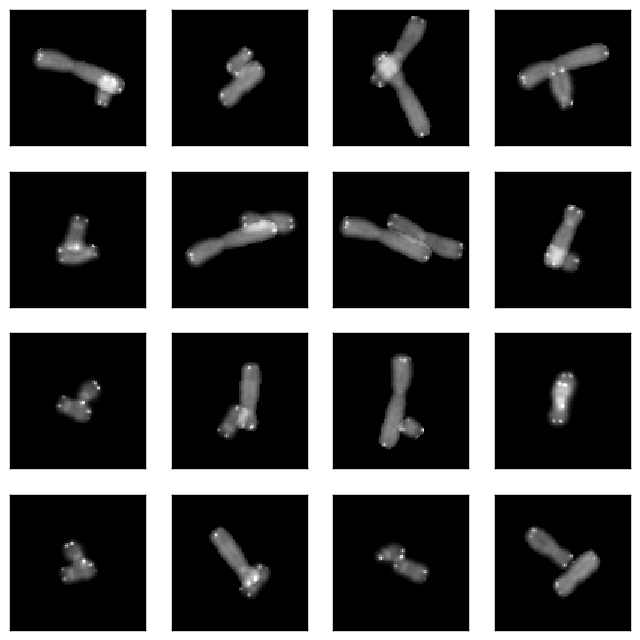

In [53]:
plt.figure(figsize=(8, 8))

for i in range(0,16):
    plt.subplot(4,4,i+1, xticks=[],yticks=[])
    im = subset_stacked[i,:,:,0]
    plt.imshow(im, interpolation='nearest', cmap = plt.cm.Greys_r,vmin=0, vmax=205)

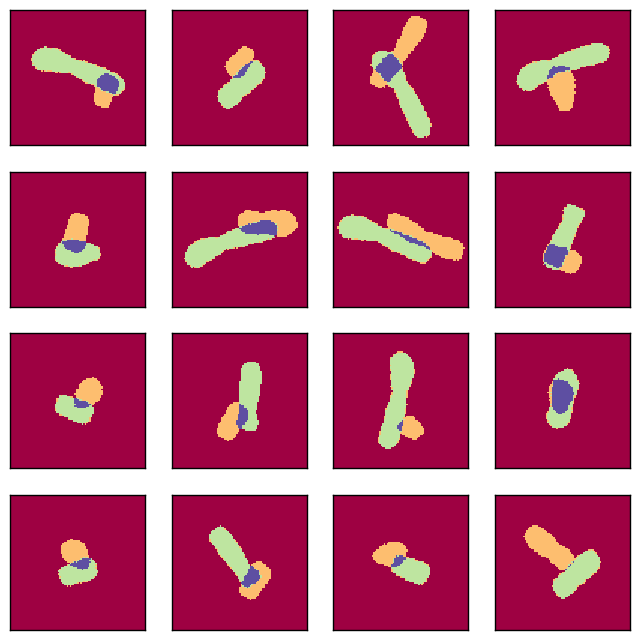

In [54]:
plt.figure(figsize=(8, 8))
for i in range(0,16):
    plt.subplot(4,4,i+1, xticks=[],yticks=[])
    im = subset_stacked[i,:,:,1]
    plt.imshow(im, interpolation='nearest', cmap = plt.cm.Spectral,vmin=0, vmax=3)

### The whole dataset have to be saved. How?
 * As a hf5 file (numpy array saved as a hf5)?
 * As individual images (eg .png)?

### Let's try hdf5 file format
The code in the above cell generate a  ~24 Mo file. 

In [1]:
h5f = h5py.File('LowRes_13434_overlapping_pairs.h5', 'w')
h5f.create_dataset('dataset_1', data= subset_stacked, compression='gzip', compression_opts=9)
h5f.close()